In [1]:
import pandas as pd

df = pd.read_csv('../data/twitter_dataset.csv')
print(df.columns)
df.head()

Index(['clean_text', 'category'], dtype='object')


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [2]:
import sys
import os
sys.path.append("..")  # or os.getcwd() depending on where the notebook is

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

from utils.preprocessing import clean_text

In [3]:
df = pd.read_csv('../data/twitter_dataset.csv') 
df = df[['clean_text', 'category']]            
df = df.rename(columns={'clean_text': 'text', 'category': 'sentiment'})  
df['cleaned_text'] = df['text'].astype(str).apply(clean_text)
df.head() 

,text,sentiment,cleaned_text
0,when modi promised “minimum government maximum...,-1.0,modi promised minimum government maximum gover...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,1.0,asking supporters prefix chowkidar names modi ...
4,answer who among these the most powerful world...,1.0,answer among powerful world leader today trump...


In [4]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_map)

In [5]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])

sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded = pad_sequences(sequences, maxlen=100, padding='post')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(padded, df['label'], test_size=0.2, random_state=42)

In [7]:
model = Sequential()
model.add(Embedding(10000, 64, input_length=100))
model.add(SimpleRNN(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/Users/ritulshekhar/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0220 - val_accuracy: 0.0000e+00 - val_loss: 2.3842e-07
Epoch 2/5
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.0000e+00 - loss: 1.5886e-07 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/5
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


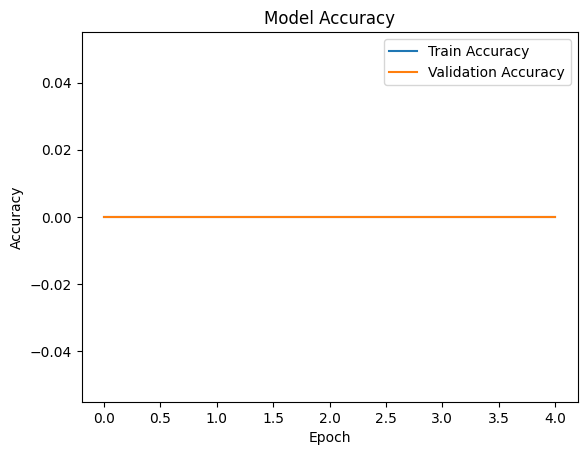

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
model.save("model/sentiment_model.keras")

with open("model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)